0 , train: 0.25 | test: 28.1 | loss: 0.011510308
200 , train: 81.735 | test: 86.0 | loss: 0.8012153
400 , train: 90.5 | test: 89.0 | loss: 0.3456835
600 , train: 92.15 | test: 90.2 | loss: 0.2831364
800 , train: 93.2 | test: 92.2 | loss: 0.24553597
1000 , train: 93.79 | test: 95.4 | loss: 0.22025277
1200 , train: 94.815 | test: 95.8 | loss: 0.19007576
1400 , train: 95.44 | test: 97.1 | loss: 0.166078
1600 , train: 95.5 | test: 97.9 | loss: 0.1647478
1800 , train: 95.825 | test: 95.1 | loss: 0.1491711
2000 , train: 96.39 | test: 95.4 | loss: 0.12916169
2200 , train: 96.5 | test: 96.0 | loss: 0.1293208
2400 , train: 96.705 | test: 96.5 | loss: 0.11940184
2600 , train: 97.13 | test: 96.2 | loss: 0.104540154
2800 , train: 97.115 | test: 95.8 | loss: 0.10305108
3000 , train: 97.27 | test: 95.9 | loss: 0.101576306
3200 , train: 97.675 | test: 97.6 | loss: 0.08465153
3400 , train: 97.425 | test: 97.7 | loss: 0.09145778
3600 , train: 97.815 | test: 97.9 | loss: 0.082694046
3800 , train: 98.205

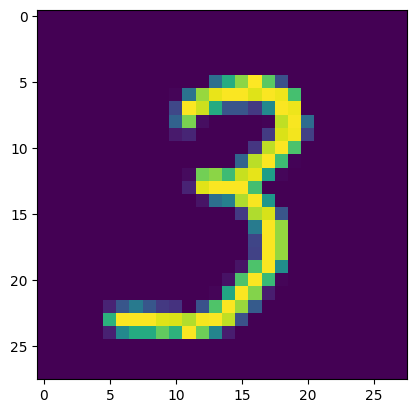

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace

# Load MNIST dataset
class Dataset():
    def __init__(self, data):
        self.data = data
        self.index = 0
        self.epochs = 0

    def shuffle(self):
        perm = np.arange(self.data[0].shape[0])
        np.random.shuffle(perm)
        self.data = tuple(datai[perm] for datai in self.data)

    def next_batch(self, batch_size):
        start = self.index
        end = self.index + batch_size
        if end > self.data[0].shape[0]:
            self.epochs += 1
            self.shuffle()
            self.index, start = 0, 0
            end = batch_size
        self.index = end
        return tuple(datai[start:end, ...] for datai in self.data)


def load_mnist():
    def preprocess(data, labels, num_classes):
        data = data.astype(np.float32) / 255.0
        data = np.reshape(data, [data.shape[0], -1])
        num_labels = labels.shape[0]
        index_offset = np.arange(num_labels) * num_classes
        labels_one_hot = np.zeros((num_labels, num_classes))
        labels_one_hot.flat[index_offset + labels.ravel()] = 1
        return data, labels_one_hot

    train, test = tf.keras.datasets.mnist.load_data()
    train = preprocess(train[0], train[1], 10)
    test = preprocess(test[0], test[1], 10)
    return SimpleNamespace(train=Dataset(train), test=Dataset(test))

mnist = load_mnist()

# Define model parameters
input_size = 28 * 28
n_outputs = 10
n_hidden = 100
batch_size = 100

# Define Dense Layer
class DenseLayer(object):
    def __init__(self, n_inputs, n_units, afunc=None, w_stddev=0.01):
        self.w = tf.Variable(
            tf.random.truncated_normal([n_inputs, n_units], stddev=w_stddev),
            name='w')
        self.b = tf.Variable(tf.zeros([n_units]), name='b')
        self.afunc = afunc

    def trainable_variables(self):
        return [self.w, self.b]

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        if self.afunc is not None:
            y = self.afunc(y)
        return y

# Define MLP Model
class MLP(object):
    def __init__(self, layers):
        self.layers = layers

    def trainable_variables(self):
        return [var for layer in self.layers for var in layer.trainable_variables()]

    def __call__(self, x, logits=False):
        output = x
        for layer in self.layers:
            output = layer(output)
        if not logits:
            output = tf.nn.softmax(output)
        return output

# Define loss function
def loss_fn(logits, labels, weights):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=logits, labels=labels))

# Build the model
model = MLP([
    DenseLayer(input_size, n_hidden, afunc=tf.nn.relu),
    DenseLayer(n_hidden, n_outputs)
])
weights = [layer.w for layer in model.layers]

# Define optimizer
optimizer = tf.keras.optimizers.Adam(1e-3)

# Define accuracy function
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

# Training loop
num_steps = 10000
summary_freq = 200
n_test_log = 10
mean_loss = 0
train_accuracy = 0

def train_step(labels, inputs):
    with tf.GradientTape() as tape:
        logits = model(inputs, logits=True)
        loss = loss_fn(logits, labels, weights)
    gradients = tape.gradient(loss, model.trainable_variables())
    optimizer.apply_gradients(zip(gradients, model.trainable_variables()))
    return loss.numpy(), model(inputs).numpy()

for step in range(num_steps):
    batch_X, batch_y = mnist.train.next_batch(batch_size)
    l, train_pred = train_step(batch_y, batch_X)
    train_accuracy += accuracy(train_pred, batch_y)
    mean_loss += l
    if step % summary_freq == 0:
        train_accuracy /= summary_freq
        test_accuracy = 0
        for i in range(n_test_log):
            batch_X_test, batch_y_test = mnist.test.next_batch(batch_size)
            pred = model(batch_X_test)
            test_accuracy += accuracy(pred, batch_y_test)
        test_accuracy /= n_test_log
        print(step, ', train:', train_accuracy, '| test:', test_accuracy, '| loss:', mean_loss / summary_freq)
        mean_loss = 0
        train_accuracy = 0

# Test the model
test_sample_x, test_sample_y = mnist.test.next_batch(1)
pred = model(test_sample_x)
print('Actual number:', np.argmax(test_sample_y))
print('Prediction by the model:', np.argmax(pred))
plt.imshow(np.reshape(test_sample_x, [28, 28]))
plt.show()